## The Battle of the Cities - Great Vancouver, Canada

### IBM Data Science Capstone project by Kyung-A Chang	

### Table of Contents
* [Introduction: Business Problem](#introduction)
* [Data Understanding](#data)
* [Methodology & Analysis](#methodology)
* [Results & Discussion](#results)
* [Conclusion](#conclusion)

### Introduction: Business Problem <a name="introduction"></a>

In this project we will try to find an optimal location for a **Korean restaurant** in the **Greater Vancouver**, British Columbia, Canada. 
Vancouver is located in the west coast Canada and has the highest population density in Canada, with over 5,400 people per square kilometre which makes it the fifth-most densely populated city with over 250,000 residents in North America. The population of Vancouver and Greater Vancouver is about **2.5 million**.  Vancouver is one of the most ethnically and linguistically diverse cities in Canada. 52% of its residents are not native English speakers, 48.9% are native speakers of either English or French, and 50.6% of residents belong to visible minority groups. The Chinese are the largest visible ethnic group in the city(26.5%). Other significant Asian ethnic groups in Vancouver are South and West Asian (7.4%), Filipino (5.9%), Japanese (1.7%), Korean (1.5%), as well as sizeable communities of Vietnamese, Indonesians, and Cambodians.

Being a high populated and ethnically diversified city, Vancouver offers multicultural restaurants in many neighbourhoods.  To reflect the high Asian population, you can easily find the Asian restaurants in most of neighbourhoods. 

Since there are lots of restaurants in Vancouver we will try to select locations that **are already crowded with existing Asian restaurants but not too many Korean restaurants in the neighbourhood**.  

This report will be targeted for any **clients who are new to the city and have interests to set up a new Korean restaurant or any clients who already own a restaurant but search for a new optimal location**.  

We will use our data science technique to generate a few most promising neighbourhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

### Data Understanding<a name="data"></a>

Based on our Business problem, factors that will influence our decision are:
number of existing Asian restaurants in the neighbourhood
number of and distance to Korean restaurants in the neighbourhood, if any

Greater Vancouver is divided by many sub cities. There are near 9000 Asian restaurants in the greater Vancouver area. With Foursquare API’s restriction returning top 100, we will loop thru the below coordinates using Foursquare API to extract the full list of Asian restaurants.   
* latitude : 49.00N ~ 49.36N
* longitude : -123.20W ~ -122.2W
* step : 0.02

**Foursquare : Venues Data**

Foursquare has venue data with categories and geo locations for food and type of restaurants. Data can be searched by area and retrieved in GeoJSON format. The Foursquare data is crowdsourced, so accuracy is not guaranteed and may have duplicate entries for the same venue and incorrect category assignments.
 
https://api.foursquare.com/v2/venues/explore?

* categoryId = {“Asian Restaurant” : 4bf58dd8d48988d142941735}
* intent = {indicating your intent in performing the search : browse} 
* sw = { limits results to the bounding box by south-west corner:  49.00, -123.18}
* ne = { limits results to the bounding box by north-east corner : 49.36, -122.7}


After initial evaluation of results from Foursquare API before data cleaning, we have 42 different types and about 1100 Asian restaurants.

This is sufficient number of restaurants to group compare restaurant density thru the greater Vancouver area. 

In [1]:
# import necessary libraries

import numpy as np
import pandas as pd
import requests
#from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize # transform JSON file into a pandas dataframe

from sklearn.cluster import KMeans
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

In [2]:
#!pip install geopy
#!conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

In [3]:
#!conda install -c conda-forge folium=0.5.0 --yes 

import folium 

In [4]:
# @hidden_cell
#address = 'Vancouver, BC'

#geolocator = Nominatim(user_agent="Vancouver_explorer")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude

#print('The geograpical coordinate of Vancouver are {}, {}.'.format(latitude, longitude))

Define Foursquare Credentials and Version

In [5]:
# @hidden_cell
# type your answer here
#LIMIT = 100
#radius = 2000
#url = "https://api.foursquare.com/v2/venues/explore?client_id=CLIENT_ID&client_secret=CLIENT_SECRET&ll=neighborhood_latitude,neighborhood_longitude&v=VERSION&limit=LIMIT"
#url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}\
#&ll={},{}&v={}&radius={}&limit={}'.format(
#CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, radius, LIMIT)

#search_query = 'restaurant'
#categoryId='4bf58dd8d48988d145941735' # Chinese restaurant
#categoryId='4bf58dd8d48988d113941735' # Korean restaurant
#categoryId='4bf58dd8d48988d142941735' # Korean restaurant
#url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
#url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&sw={},{}&ne={},{}&v={}&categoryId={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, sw_latitude, sw_longitude, ne_latitude, ne_longitude, VERSION, categoryId, LIMIT)



#url

Foursquare API : Foursquare has venue data with categories and geo locations for food and type of restaurants. Data can be searched by area and retrieved in GeoJSON format

       https://api.foursquare.com/v2/venues/explore?

* **categoryId** = {“Asian Restaurant” : 4bf58dd8d48988d142941735}
* **intent** = {indicating your intent in performing the search : browse} 
* **sw** = { limits results to the bounding box by south-west corner:  49.00, -123.18}
* **ne** = { limits results to the bounding box by north-east corner : 49.36, -122.7}

### Methodology & Analysis <a name="methodology"></a>
* I have to figure out what Foursquare API option I use for this project. As Foursquare API limits the number of returning query 100 for explore option and 50 for search option, I try with the explore option.  After run a few initial Foursquare queries, my result sets are over 100 for each cities.  The result sets were reaching 100 every time.  Then I discover that bounding box option can be used to narrow down the search query if I select the smaller area.  The bounding box is required to have two points, SW and NE, then it pull the venue results within that boundary.  

* As I am using Foursquare API bounding box option,  I need to figure out the correct coordinates that cover the full Greater Vancouver region.  Since Greater Vancouver does not have defined coordinates, I had to go thru the all the cities in the boundary to find the right coordinate using google map.  

* After collect the required data,  I need to check for the duplicated entries since I never used bounding box options before.  

* Foursquare data is crowded data so the venue categories were not very consistently populated.  I have to merge, join, clean the data before using it.  Also I had to search some of restaurant’s name to determine the correct category for ambiguous entries.  

* I use K-Means Clustering algorithm to cluster the restaurants by coordinates. K-Means algorithm is one of the most common cluster method of unsupervised learning. Latitude and Longitude are used as the features. First I find the optimal K with K-Means with elbow method. 

* Finally I focus on the most promising area where high populated with Asian restaurants but lower number of Korean restaurant to meet my project’s requirement.  


In [6]:
# function to call Foursquare API using bounding box options.

def foursquare(new_sw_latitude, new_sw_longitude, new_ne_latitude, new_ne_longitude):
# @hidden_cell
    CLIENT_ID = 'M45GUPMUJY2QUKJTVR5COOBBOGMWVTXCECKDOZN40MCXWQS5' # your Foursquare ID
    CLIENT_SECRET = '20YMK3Y510PMJY015NIA0TWTI4CUUCJMRWZQ0ZDWDR55P1Z5' # your Foursquare Secret
    VERSION = '20180605' # Foursquare API version
    LIMIT = 100
    categoryId='4bf58dd8d48988d142941735' # Asian Restaurant
#    categoryId='4d4b7105d754a06374d81259' #Food
    sw_latitude = new_sw_latitude
    sw_longitude = new_sw_longitude
    ne_latitude = new_ne_latitude
    ne_longitude = new_ne_longitude
    intent='browse'

    url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&sw={},{}&ne={},{}&v={}&categoryId={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, sw_latitude, sw_longitude, ne_latitude, ne_longitude, VERSION, categoryId, intent, LIMIT)
#    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&sw={},{}&ne={},{}&v={}&categoryId={}&intent={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, sw_latitude, sw_longitude, ne_latitude, ne_longitude, VERSION, categoryId, intent, LIMIT)


#    print(url)

    results = requests.get(url).json()
    return results

In [7]:
# function to get the category type from GeoJson data.

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
    
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']


Let's clean the json and structure it into a pandas dataframe

In [8]:
#venues = results['response']['venues']
def get_data_create_temp(results):
    try: # to check if JSON return the empty body
        venues = results['response']['groups'][0]['items']    

        nearby_venues = json_normalize(venues) # flatten JSON
        filtered_columns = ['venue.name', 'venue.categories','venue.location.lat', 'venue.location.lng', 'venue.location.address', 'venue.location.city']

        nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row

        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)


# clean columns
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

        nearby_venues.head()
    except:
        nearby_venues = pd.DataFrame()

        
    if nearby_venues.shape[0] == 0:  # JSON returned the empty body, we will return None
        return None
    else :        
        return nearby_venues



Now we need to retrieve the data calling Foursquare API using bounding box option(coordination SW and NE per each query). 
The range of longitude is -123.20 ~ -122.20. 
The range of latitude is 49.00 ~ 49.36.
This range should full cover the coordination of the greater Vancouver.
The below code is looping numerous time by reducing the longitude by 0.02.   

In [9]:

count = 0
# The range I do search restaurants are 
# latitude 49.00 - 49.36
# longitude -123.18 ~ -122.2
for x in np.arange(-123.20, -122.2, 0.02) : # this will run range of longitude / 0.02

#    print('count', count, 'x : ', x)
    if count == 0: # first time running.  Just assign SW coordinates
        sw_latitude = 49.00 # assign the most South coordinate
        sw_longitude = x # assing the South West coordinate
        count += 1
    elif count == 1: # second time running.  Now we can assign NE coordinates and call Foursquare API
        ne_latitude = 49.36 # assign the most North latitude.  This value will be changing
        ne_longitude = x # assing the most North East longitude.
        results = foursquare(sw_latitude, sw_longitude, ne_latitude, ne_longitude)
        temp_df = get_data_create_temp(results) # create a temp dataframe

        master_df = temp_df # create a master_df to holding all the coordinates
        count += 1
        prev_ne_longitude = ne_longitude # assign the current ne longitude to previous ne longitude
    else:
        sw_latitude = sw_latitude # assign the previous sw latitude to the current sw latitude
        sw_longitude = prev_ne_longitude # assign the previous ne longitude to the current ne longitude 
        new_ne_latitude = ne_latitude # assign the previous ne latitude to the current ne latitude
        new_ne_longitude = x # assign a new ne longitude
        results = foursquare(sw_latitude, sw_longitude, new_ne_latitude, new_ne_longitude)
        temp_df = get_data_create_temp(results) # create a temp dataframe
  
        master_df = master_df.append(temp_df, ignore_index = True) # append the temp dataframe to the master dataframe
        count += 1  
        prev_ne_longitude = new_ne_longitude # assign the current ne longitude to the previous ne logitude


master_df.shape

(1101, 6)

In [10]:
# save to a csv file in case the API calling can be limited/restricted
master_df.to_csv(r'master_df.csv')


In [11]:
#master_df = pd.read_csv('master_df.csv')

In [12]:
#master_df.drop('Unnamed: 0', axis=1, inplace=True)

After calling Foursquare explore quary and the data has saved to master_df.  
We will see how many restaurants have been returned. 

In [13]:
print('{} venues were returned by Foursquare.'.format(master_df.shape))

(1101, 6) venues were returned by Foursquare.


In [14]:
# @hidden_cell
#address = 'Coquitlam, BC'

#geolocator = Nominatim(user_agent="Vancouver_explorer")
#location = geolocator.geocode(address)
#latitude = location.latitude
#longitude = location.longitude

#CLIENT_ID = 'M45GUPMUJY2QUKJTVR5COOBBOGMWVTXCECKDOZN40MCXWQS5' # your Foursquare ID
#CLIENT_SECRET = '20YMK3Y510PMJY015NIA0TWTI4CUUCJMRWZQ0ZDWDR55P1Z5' # your Foursquare Secret
#VERSION = '20180605' # Foursquare API version
#LIMIT = 50
#radius=2000
#categoryId='4bf58dd8d48988d142941735' # Asian Restaurant

#print('The geograpical coordinate of Coquitlam are {}, {}.'.format(latitude, longitude))

#url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, categoryId, radius, LIMIT)
#print(url)
#results = requests.get(url).json()
#temp_df = get_data_create_temp(results)
#master_df = master_df.append(temp_df, ignore_index = True)





### Data Cleaning 
Now we have data stored in master_df, we will start wranggling. 
* First check the duplicated rows in case the API returned any.
* We will see how many different categories of restaurants in our data.
* We will merge some categories restaurants where "Sushi Restaurant" to "Japanese Restaurant"
* If still too many categories, we will reduced to less than 10 categories.

In [15]:
# Check if there is any duplicaed rows.

duplicate = master_df.duplicated()
duplicate[duplicate==True]
master_df.reset_index(drop=True, inplace=True)

In [16]:
#master_df.drop_duplicates(inplace=True, keep='first' )

In [17]:
# print number of restaurants and number of categories
print(master_df.shape)
print(len(master_df["categories"].value_counts()))
master_df.head()

(1101, 6)
43


,name,categories,lat,lng,address,city
0,Green Leaf,Sushi Restaurant,49.264206,-123.180101,3416 West Broadway,Vancouver
1,Ora Sushi,Sushi Restaurant,49.125278,-123.183891,3651 Moncton St,Richmond
2,Red Tuna,Japanese Restaurant,49.234746,-123.184952,3592 W 41st Ave,Vancouver
3,The Eatery,Japanese Restaurant,49.264279,-123.180756,3431 W Broadway,Vancouver
4,Rajio Japanese Public House,Japanese Restaurant,49.263516,-123.187086,3763 W 10th Ave,Vancouver


It looks like 1101 restaurants and 43 types of restaurants are returned from Foursquare API. Let's see how many restaurants under each categories.

In [18]:
master_df["categories"].value_counts()

Sushi Restaurant                 226
Chinese Restaurant               190
Japanese Restaurant              145
Vietnamese Restaurant            127
Asian Restaurant                 112
Korean Restaurant                 80
Thai Restaurant                   58
Noodle House                      26
Ramen Restaurant                  22
Malay Restaurant                  17
Dim Sum Restaurant                16
Taiwanese Restaurant              10
Cantonese Restaurant               9
Szechuan Restaurant                6
Shanghai Restaurant                5
Coffee Shop                        5
Filipino Restaurant                5
Vegetarian / Vegan Restaurant      4
Hotpot Restaurant                  4
Food Court                         4
Shabu-Shabu Restaurant             2
Seafood Restaurant                 2
Food Truck                         2
Bubble Tea Shop                    2
Bakery                             2
BBQ Joint                          2
Café                               2
D

It looks like we can merge some categores.  
* "Sushi Restuarant", "Ramen Restaurant", "Japanese Curry Restaurant" and "Shabu-Shabu Restaurant" can merge into "Japanese Restaurant"
* "Shanghai Restaurant", "Cantonese Restaurant", "Dim Sum Restaurant", "Szechuan Restaurant", "Dumpling Restaurant", "Indian Chinese Restaurant", "Taiwanese Restaurant" merge into "Chinese Restaurant"

In [19]:
master_df.drop(master_df.loc[master_df["categories"] == "Flea Market"].index, inplace=True)

In [20]:
master_df['categories'].replace(to_replace=['Sushi Restaurant'],value=["Japanese Restaurant"],inplace=True)

In [21]:
master_df['categories'].replace(to_replace=['Ramen Restaurant'],value=["Japanese Restaurant"],inplace=True)

In [22]:
master_df['categories'].replace(to_replace=['Japanese Curry Restaurant'],value=["Japanese Restaurant"],inplace=True)

In [23]:
master_df['categories'].replace(to_replace=['Shabu-Shabu Restaurant'],value=["Japanese Restaurant"],inplace=True)

In [24]:
master_df['categories'].replace(to_replace=['Shanghai Restaurant'],value=["Chinese Restaurant"],inplace=True)

In [25]:
master_df['categories'].replace(to_replace=['Cantonese Restaurant'],value=["Chinese Restaurant"],inplace=True)

In [26]:
master_df['categories'].replace(to_replace=['Dim Sum Restaurant'],value=["Chinese Restaurant"],inplace=True)

In [27]:
master_df['categories'].replace(to_replace=['Szechuan Restaurant'],value=["Chinese Restaurant"],inplace=True)

In [28]:
master_df['categories'].replace(to_replace=['Dumpling Restaurant'],value=["Chinese Restaurant"],inplace=True)

In [29]:
master_df['categories'].replace(to_replace=['Indian Chinese Restaurant'],value=["Chinese Restaurant"],inplace=True)


In [30]:
master_df['categories'].replace(to_replace=['Taiwanese Restaurant'],value=["Chinese Restaurant"],inplace=True)



In [31]:
print(len(master_df["categories"].value_counts()))
master_df["categories"].value_counts()

32


Japanese Restaurant              396
Chinese Restaurant               238
Vietnamese Restaurant            127
Asian Restaurant                 112
Korean Restaurant                 80
Thai Restaurant                   58
Noodle House                      26
Malay Restaurant                  17
Coffee Shop                        5
Filipino Restaurant                5
Vegetarian / Vegan Restaurant      4
Food Court                         4
Hotpot Restaurant                  4
BBQ Joint                          2
Café                               2
Bakery                             2
Bubble Tea Shop                    2
Seafood Restaurant                 2
Food Truck                         2
Diner                              1
Fast Food Restaurant               1
Donut Shop                         1
Lounge                             1
Ice Cream Shop                     1
Taco Place                         1
Fried Chicken Joint                1
Tea Room                           1
R

We still have 32 categories.  Let's create a new dataframe for top 8 categories

In [32]:
new_df = master_df[master_df['categories'].str.contains('Chinese', regex=False)]
new_df = new_df.append(master_df[master_df['categories'].str.contains('Korea', regex=False)])
new_df = new_df.append(master_df[master_df['categories'].str.contains('Japan', regex=False)])
new_df = new_df.append(master_df[master_df['categories'].str.contains('Vietnamese', regex=False)])
new_df = new_df.append(master_df[master_df['categories'].str.contains('Thai', regex=False)])
new_df = new_df.append(master_df[master_df['categories'].str.contains('Noodle', regex=False)])
new_df = new_df.append(master_df[master_df['categories'].str.contains('Malay', regex=False)])
new_df = new_df.append(master_df[master_df['categories'].str.contains('Asian', regex=False)])
new_df.reset_index(drop=True, inplace=True)
new_df.shape



(1054, 6)

Notice categories "Asian Restaurant" has 112 and it is ambiguous.  We will merge more for some obvious entries. 

In [33]:
new_df[new_df['categories'].str.contains('Asian')]

,name,categories,lat,lng,address,city
942,Iron Wok,Asian Restaurant,49.268295,-123.186468,#255 - 2083 Alma Street,Vancouver
943,G-Men Ramen (Steveston),Asian Restaurant,49.124406,-123.184630,3711 Bayview Street,Richmond
944,Taste of Thai,Asian Restaurant,49.264362,-123.184758,3629 W Broadway,Vancouver
945,Rice Tales,Asian Restaurant,49.195574,-123.184180,Vancouver International Airport (YVR),Richmond
946,Strike,Asian Restaurant,49.264298,-123.176555,3217 West Broadway,Vancouver
...,...,...,...,...,...,...
1049,Lotus Garden Express,Asian Restaurant,49.103670,-122.492202,26426 56 Ave,Township of Langley
1050,Wok Box,Asian Restaurant,49.050430,-122.325552,32500 S Fraser Way,Abbotsford
1051,Noodle Road,Asian Restaurant,49.044716,-122.338340,#24 31940 south fraser way,Abbotsford
1052,Thai Express,Asian Restaurant,49.049673,-122.312753,"32900 South Fraser Way,Sevenoaks Shopping Centre",Abbotsford


In [34]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Chinese'), 'categories'] = 'Chinese Restaurant'

In [35]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('China'), 'categories'] = 'Chinese Restaurant'

In [36]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Wok'), 'categories'] = 'Chinese Restaurant'

In [37]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Japan'), 'categories'] = 'Japanese Restaurant'

In [38]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Banana Leaf'), 'categories'] = 'Malay Restaurant'

In [39]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Sushi'), 'categories'] = 'Japanese Restaurant'

In [40]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Ramen'), 'categories'] = 'Japanese Restaurant'

In [41]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Szechuan'), 'categories'] = 'Chinese Restaurant'

In [42]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Pearl'), 'categories'] = 'Chinese Restaurant'

In [43]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Palace'), 'categories'] = 'Chinese Restaurant'

In [44]:
new_df.loc[new_df['categories'].str.contains('Asian') & new_df['name'].str.contains('Dynasty'), 'categories'] = 'Chinese Restaurant'

In [45]:
new_df[new_df['categories'].str.contains('Asian')]

,name,categories,lat,lng,address,city
944,Taste of Thai,Asian Restaurant,49.264362,-123.184758,3629 W Broadway,Vancouver
945,Rice Tales,Asian Restaurant,49.195574,-123.184180,Vancouver International Airport (YVR),Richmond
946,Strike,Asian Restaurant,49.264298,-123.176555,3217 West Broadway,Vancouver
949,MAK N MING,Asian Restaurant,49.271230,-123.155032,1629 Yew Street,Vancouver
950,Noodlebox,Asian Restaurant,49.268096,-123.147275,1867 West 4th Avenue,Vancouver
...,...,...,...,...,...,...
1045,Ban Chok Dee,Asian Restaurant,49.103026,-122.652841,20563 Douglas Crescent,Township of Langley
1049,Lotus Garden Express,Asian Restaurant,49.103670,-122.492202,26426 56 Ave,Township of Langley
1051,Noodle Road,Asian Restaurant,49.044716,-122.338340,#24 31940 south fraser way,Abbotsford
1052,Thai Express,Asian Restaurant,49.049673,-122.312753,"32900 South Fraser Way,Sevenoaks Shopping Centre",Abbotsford


In [46]:
new_df.shape[0]


1054

Let's see the percentage

In [47]:
percentage_korean_rest =(new_df.categories[new_df['categories']=='Korean Restaurant'].count()/new_df.shape[0]) * 100


print('the percetage of Korean Restaurants in Greater Vancouver is {:.2f}'.format(percentage_korean_rest))

the percetage of Korean Restaurants in Greater Vancouver is 7.59


Now we want to clustering the restaurants.  I use K-Means Clustering algorithm to cluster the restaurants. K-Means algorithm is one of the most common cluster method of unsupervised learning. Latitude and Longitude will be used as the features.
First I want to find the optimal K with K-Means with elbow method.

In [48]:
# create a new dataframe just for lat and lng.  This dataframe will be used for K-Means algorithm.
van_geodata = new_df[["lat","lng"]]

## K-Means with elbow method.
Run K-means with elbow method to find an optimal K


In [49]:
# run K-means with k = 1 ~ 15.
sum_of_squared_distances = []
kclusters = range(1, 15)
for k in kclusters:
    kmeans = KMeans(n_clusters = k, random_state=0).fit(van_geodata)
    kmeans.labels_
    sum_of_squared_distances.append(kmeans.inertia_)

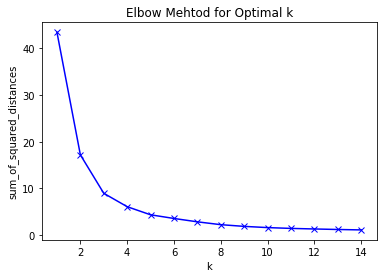

In [50]:
plt.plot(kclusters, sum_of_squared_distances,'bx-')
plt.xlabel('k')
plt.ylabel('sum_of_squared_distances')
plt.title('Elbow Mehtod for Optimal k')
plt.show()

It looks like **6** is the **optimal K** per elbow method.


## K-Means Clustering Algorithm with K = 6

In [51]:
kclusters = 6
kmeans = KMeans(n_clusters = kclusters, random_state=0).fit(van_geodata)



In [52]:
kmeans.labels_

array([1, 1, 1, ..., 3, 3, 3], dtype=int32)

In [53]:
centeroid = kmeans.cluster_centers_ # find the centroid of 8 clusters

In [54]:
centeroid

array([[  49.23579085, -122.84510946],
       [  49.24828937, -123.12938478],
       [  49.15462665, -122.65233233],
       [  49.05885618, -122.3257686 ],
       [  49.24336299, -123.01302586],
       [  49.10127885, -122.81590928]])

## Google Maps API reverse geocoding

After find the centre of each clusters, the city name will be obtained using the coordinates of the centre points. city_df dataframe is populated with city name.


In [55]:
locator = Nominatim(user_agent = "myGeocoder")
#coordinates = "49.26208669, -123.14957017"
city = []
for i in range(len(centeroid)):
    coordinates = centeroid[i]

    location = locator.reverse(coordinates)
    coord = location.raw
    address = coord['address']
    city.append(address['city'])
 #   city_df['Cluster Labels'] = i
city_df = pd.DataFrame(city)

In [56]:
city_df["Cluster Labels"] = city_df.index # add Cluster labels

In [57]:
city_df.rename(columns={0:'city_name'}, inplace=True) # Rename first column to be city_name

In [58]:
city_df[['latitude', 'longitude']] = pd.DataFrame(centeroid, index=city_df.index) # add coordinates of each centroid to the dataframe



In [59]:
city_df

,city_name,Cluster Labels,latitude,longitude
0,Coquitlam,0,49.235791,-122.845109
1,Vancouver,1,49.248289,-123.129385
2,Township of Langley,2,49.154627,-122.652332
3,Abbotsford,3,49.058856,-122.325769
4,Burnaby,4,49.243363,-123.013026
5,Surrey,5,49.101279,-122.815909


In [60]:
#new_df.drop('Cluster Labels', axis=1,inplace=True)

In [61]:

new_df.insert(0, 'Cluster Labels', kmeans.labels_) # add Cluser Labels to the restaurant dataframe

In [62]:
new = city_df.merge(new_df, on=['Cluster Labels']) # Merge two dataframes on Cluster Labels.

We have merged two dataframes into one.  
This contains 
* cluster city name, 
* coordinate of centeroid for each clusters
* name of the restaurant
* category of the restaurant
* coordinates of the restaurant
* address of the restaurant
* city name of the restaurant

In [63]:
new.head()

,city_name,Cluster Labels,latitude,longitude,name,categories,lat,lng,address,city
0,Coquitlam,0,49.235791,-122.845109,New West Wonton House,Chinese Restaurant,49.205498,-122.928983,441 - 12th street,New Westminster
1,Coquitlam,0,49.235791,-122.845109,New Lakeview Restaurant,Chinese Restaurant,49.220520,-122.929862,7763 6th street,New Westminster
2,Coquitlam,0,49.235791,-122.845109,North Noodle House,Chinese Restaurant,49.201135,-122.913047,356 - 800 Carnarvon St,New Westminster
3,Coquitlam,0,49.235791,-122.845109,Hon's Wun-Tun House,Chinese Restaurant,49.210435,-122.917081,408 - 6th Street,New Westminster
4,Coquitlam,0,49.235791,-122.845109,Wild Rice,Chinese Restaurant,49.200105,-122.911185,810 Quayside Dr,New Westminster


This shows how many restaurants under each clusters. 

In [64]:
new['city_name'].value_counts()

Vancouver              338
Coquitlam              265
Burnaby                265
Township of Langley     80
Surrey                  70
Abbotsford              36
Name: city_name, dtype: int64

New datafram is created for the **plotting**.  We want to **group them by city and categories**

In [65]:
tmp_df = new[['city_name', 'categories']]
tmp_df.shape

(1054, 2)

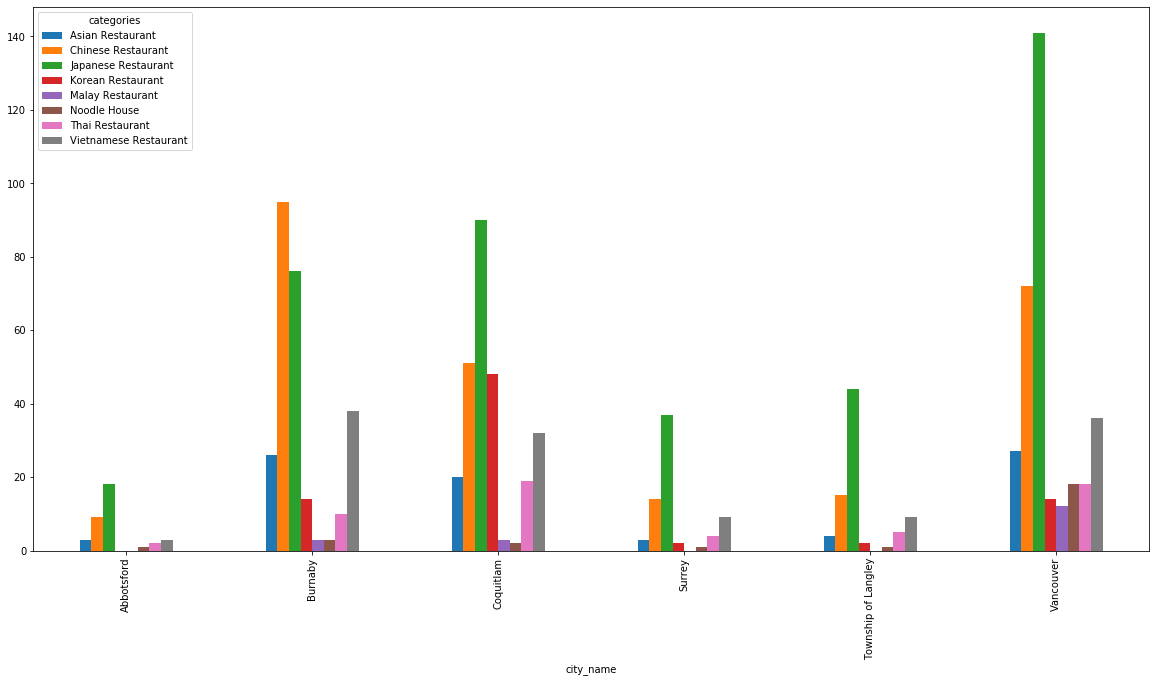

In [66]:
fig, ax = plt.subplots(figsize= (20, 10))
tmp_df.groupby(['city_name'])['categories'].value_counts().unstack().plot(kind='bar', ax=ax)

From the plot, **Vancouver cluster has the most restaurants and not too many Korean restaurants**.
This cluster may be the good candidate for our goal.

In [67]:
tmp_df.groupby(['city_name'])['categories'].value_counts()

city_name            categories           
Abbotsford           Japanese Restaurant       18
                     Chinese Restaurant         9
                     Asian Restaurant           3
                     Vietnamese Restaurant      3
                     Thai Restaurant            2
                     Noodle House               1
Burnaby              Chinese Restaurant        95
                     Japanese Restaurant       76
                     Vietnamese Restaurant     38
                     Asian Restaurant          26
                     Korean Restaurant         14
                     Thai Restaurant           10
                     Malay Restaurant           3
                     Noodle House               3
Coquitlam            Japanese Restaurant       90
                     Chinese Restaurant        51
                     Korean Restaurant         48
                     Vietnamese Restaurant     32
                     Asian Restaurant          20
       

Let's explore more with top 2 categories and Korean restaurant to confirm our assumption.
Only pull **Chinese, Japanes, and Korean** for the categories. 

In [68]:
chin_jap_korea = tmp_df[tmp_df['categories'].str.contains('Chinese', regex=False)]
chin_jap_korea = chin_jap_korea.append(tmp_df[tmp_df['categories'].str.contains('Korea', regex=False)])
chin_jap_korea = chin_jap_korea.append(tmp_df[tmp_df['categories'].str.contains('Japan', regex=False)])


chin_jap_korea.shape

#chinese = nearby_venues[nearby_venues["categories"].str.contains("Chinese" , regex=False)]

(742, 2)

There are 742 restaurants for Chinese, Japanese, and Korean Restaurant categories.  Let's plot them to see if we get the same result. 

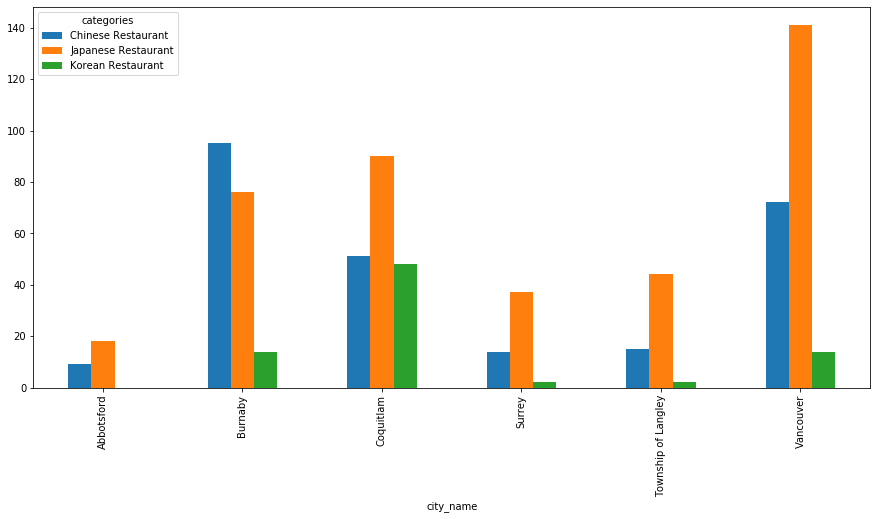

In [69]:
fig, ax = plt.subplots(figsize= (15, 7))
chin_jap_korea.groupby(['city_name'])['categories'].value_counts().unstack().plot(kind='bar', ax=ax)



From the plotting, we see the same result.  **Vancouver** has the most restaurants and less Korean restuarnts.

In [70]:
chin_jap_korea.groupby(['city_name'])['categories'].value_counts()

city_name            categories         
Abbotsford           Japanese Restaurant     18
                     Chinese Restaurant       9
Burnaby              Chinese Restaurant      95
                     Japanese Restaurant     76
                     Korean Restaurant       14
Coquitlam            Japanese Restaurant     90
                     Chinese Restaurant      51
                     Korean Restaurant       48
Surrey               Japanese Restaurant     37
                     Chinese Restaurant      14
                     Korean Restaurant        2
Township of Langley  Japanese Restaurant     44
                     Chinese Restaurant      15
                     Korean Restaurant        2
Vancouver            Japanese Restaurant    141
                     Chinese Restaurant      72
                     Korean Restaurant       14
Name: categories, dtype: int64

In [71]:
chin_jap_korea.head()

,city_name,categories
0,Coquitlam,Chinese Restaurant
1,Coquitlam,Chinese Restaurant
2,Coquitlam,Chinese Restaurant
3,Coquitlam,Chinese Restaurant
4,Coquitlam,Chinese Restaurant


You can see the clustered map of Vancouver in the below.  Each clusters show in a different colour.  **Korean Restaurant is showing in green marker.**

In [72]:
# create map
latitude = 49.18
longitude = -122.80
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=10)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cat, name, cluster in zip(new['lat'], new['lng'], new['categories'], new['city_name'], new['Cluster Labels']):
    label = folium.Popup(str(cat) + ': city ' + str(name), parse_html=True)
    if cat == "Korean Restaurant": r = 5
    else: r = 2
    folium.features.CircleMarker(
        [lat, lon],
        radius= r,
        popup=label,
        color='green' if cat == "Korean Restaurant" else rainbow[cluster-1],
        fill=True,
        fill_color="green" if cat == "Korean Restaurant" else rainbow[cluster-1],
        fill_opacity=0.7
    ).add_to(map_clusters)
       
map_clusters



Now we will explore more for the **Vancouver cluster**.  It has **338** restaurants. Let's see the distribution of the restaurant in Vancouver cluster

In [73]:
candidate_df = new[new['city_name'] == 'Vancouver']
candidate_df.shape

(338, 10)

In [74]:
candidate_df.reset_index(drop=True, inplace=True)
candidate_df.head()


,city_name,Cluster Labels,latitude,longitude,name,categories,lat,lng,address,city
0,Vancouver,1,49.248289,-123.129385,Timmy Kitchen,Chinese Restaurant,49.124282,-123.183319,100-3791 Bayview Street,Richmond
1,Vancouver,1,49.248289,-123.129385,Imperial City Bistro,Chinese Restaurant,49.170016,-123.182943,140 - 3671 Westminster Hwy,Richmond
2,Vancouver,1,49.248289,-123.129385,Wok n' Roll,Chinese Restaurant,49.193673,-123.181371,YVR Airport,Richmond
3,Vancouver,1,49.248289,-123.129385,Simon's Kitchen,Chinese Restaurant,49.246982,-123.185160,4418 Dunbar,Vancouver
4,Vancouver,1,49.248289,-123.129385,Lok's Chinese Restaurant,Chinese Restaurant,49.234686,-123.161839,2436 West 41st Avenue,Vancouver


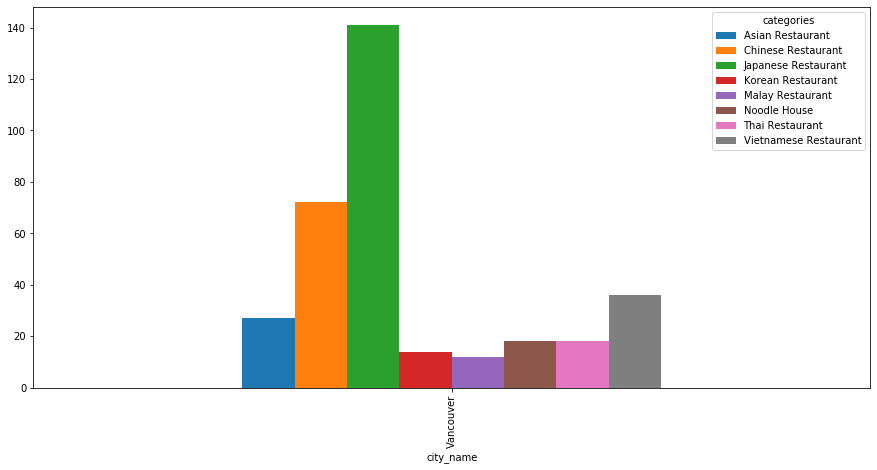

In [75]:
fig, ax = plt.subplots(figsize= (15, 7))
candidate_df.groupby(['city_name'])['categories'].value_counts().unstack().plot(kind='bar', ax=ax)



In [76]:
candidate_df['categories'].value_counts()

Japanese Restaurant      141
Chinese Restaurant        72
Vietnamese Restaurant     36
Asian Restaurant          27
Noodle House              18
Thai Restaurant           18
Korean Restaurant         14
Malay Restaurant          12
Name: categories, dtype: int64

In [77]:
percentage_korean_rest =(candidate_df.categories[candidate_df['categories']=='Korean Restaurant'].count()/candidate_df.shape[0]) * 100


print('the percetage of Korean Restaurants in Vancouver cluster is {:.2f}'.format(percentage_korean_rest))

the percetage of Korean Restaurants in Vancouver cluster is 4.14


The **percentage of the Korean restaurant** in the **greater Vancouver** was **7.59%**.  
The **percentage of the Korean Restaurant** in **Vancouver Cluster** is definitely **4.14%** 

Finally plot the restaurant in the Vancouver cluster. 

In [83]:
# create map
latitude = candidate_df.iloc[0].latitude
longitude = candidate_df.iloc[0].longitude
map_candidate = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
#x = np.arange(kclusters)
#ys = [i + x + (i*x)**2 for i in range(kclusters)]
#colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
#rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cat, name, cluster in zip(candidate_df['lat'], candidate_df['lng'], candidate_df['categories'], candidate_df['city_name'], new['Cluster Labels']):
    label = folium.Popup(str(cat) + ': city ' + str(name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color='red' if cat == "Korean Restaurant" else 'blue',
        fill=True,
#        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_candidate)
       
map_candidate




### Result & Discussion <a name="results"></a>

* It’s worth noting that Foursquare API only returned 25 Korean restaurants without specifying “intent=browse”. The default is “intent=checkin” which does not return restaurants if you are outside of Foursquare defined check-in area

* This analysis shows that although there is over 1000 Asian restaurants in the Greater Vancouver area, Vancouver city offers the best location for the new Korean restaurant venue.  Burnaby and Coquitlam shows very similar number of total Asian restaurants but Coquitlam has 3.4 times more Korean restaurants than Burnaby.

*  I used the K-Means algorithm as part of this cluster studying. When I tested the K-Means with Elbow method, the optimal K can be 6 to 10.  After I tested with different value, the results were not too different.  Therefore I selected 6 as my optimal K.

* I ended up the study by visualizing the Vancouver clustering information on the Greater Vancouver map.  For the future study, the distance between Korean restaurants/Asian restaurants can be calculated and considered as another feature


    

### Conclusion <a name="conclusion"></a>

* Purpose of this project was to identify an optimal city/neighbourhood in the Greater Vancouver region for a new Korean restaurant.  By calculating restaurant density distribution from Foursquare data, we narrowed down the candidates into 6 cities. Then further study of the clustering data, we selected the final location. Final decision on optimal restaurant location will be made by stakeholders based on specific characteristics of neighbourhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighbourhood etc.